# Tech Challenge - Análise de Atrasos de Voos

**O problema** </br>
O transporte aéreo é uma parte vital da infraestrutura global, mas os 
atrasos de voos impactam milhões de passageiros todos os anos. Neste projeto, 
você utilizará o conjunto de dados público que contém informações detalhadas 
sobre voos nos EUA para desenvolver análises e modelos preditivos e/ou 
exploratórios aplicando técnicas de Machine Learning supervisionado e não 
supervisionado. 

**Objetivos do Projeto** </br>
Aplicar o conhecimento adquirido sobre modelagem supervisionada e não 
supervisionada e desenvolver um pipeline completo de ciência de dados, desde 
a exploração dos dados até a interpretação dos resultados. 

## Exploração dos dados

In [76]:
import pandas as pd

# Carregar os dados dos arquivos CSV
flights_df = pd.read_csv('flights.csv')
airlines_df = pd.read_csv('airlines.csv')
airports_df = pd.read_csv('airports.csv')

C:\Users\Carol\AppData\Local\Temp\ipykernel_19180\16231848.py:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv('flights.csv')


Inicialmente, vamos observar apenas as primeiras linhas do nosso dataframe, selecionando apenas as colunas relevantes com informações de atrasos. Com elas já conseguimos extrair algumas informações importantes.

In [60]:
# Copiando o dataframe principal e exibindo as primeiras linhas
df_convert_time_delay = flights_df.copy()

# Função para formatar horas no formato HHMM para HH:MM para melhor visualização
def format_heure(heure):
    if pd.isna(heure):
        return None
    heure_str = str(int(heure)).zfill(4)
    return f"{heure_str[:2]}:{heure_str[2:]}"

df_convert_time_delay['SCHEDULED_DEPARTURE'] = df_convert_time_delay['SCHEDULED_DEPARTURE'].apply(format_heure)
df_convert_time_delay['DEPARTURE_TIME'] = df_convert_time_delay['DEPARTURE_TIME'].apply(format_heure)
df_convert_time_delay['SCHEDULED_ARRIVAL'] = df_convert_time_delay['SCHEDULED_ARRIVAL'].apply(format_heure)
df_convert_time_delay['ARRIVAL_TIME'] = df_convert_time_delay['ARRIVAL_TIME'].apply(format_heure)

cols_relevant = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

df_convert_time_delay[cols_relevant][:10]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,00:05,23:54,-11.0,04:30,04:08,-22.0
1,00:10,00:02,-8.0,07:50,07:41,-9.0
2,00:20,00:18,-2.0,08:06,08:11,5.0
3,00:20,00:15,-5.0,08:05,07:56,-9.0
4,00:25,00:24,-1.0,03:20,02:59,-21.0
5,00:25,00:20,-5.0,06:02,06:10,8.0
6,00:25,00:19,-6.0,05:26,05:09,-17.0
7,00:30,00:44,14.0,08:03,07:53,-10.0
8,00:30,00:19,-11.0,05:45,05:32,-13.0
9,00:30,00:33,3.0,07:11,06:56,-15.0


### Explicação sobre Valores Negativos e Positivos em ARRIVAL_DELAY e DEPARTURE_DELAY

Após a análise descritiva acima, é importante esclarecer o significado dos valores nas colunas `ARRIVAL_DELAY` e `DEPARTURE_DELAY`:

- **Valores positivos** (maiores que 0): Indicam atrasos. Para `ARRIVAL_DELAY`, o voo chegou atrasado; para `DEPARTURE_DELAY`, o voo partiu atrasado.
- **Valores negativos** (menores que 0): Indicam chegadas ou partidas adiantadas. Para `ARRIVAL_DELAY`, o voo chegou antes do horário programado; para `DEPARTURE_DELAY`, o voo partiu antes do horário programado.
- **Valor zero**: Chegada ou partida exatamente no horário programado.

Na nossa análise, focamos apenas nos valores positivos para calcular estatísticas de atrasos, pois os negativos representam chegadas ou partidas antecipadas, não atrasos. Isso garante que nossas métricas reflitam apenas os casos de atraso, evitando distorções na interpretação dos dados.

### Estatísticas Descritivas
Antes de iniciarmos as análises, vamos analisar também valores nulos na coluna ARRIVAL_DELAY. Onde ARRIVAL_DELAY for nulo, vamos calcular ele através da diferença das colunas SCHEDULED_ARRIVAL e ARRIVAL_TIME, se presentes.

In [73]:
print(f"Quantidade de ARRIVAL_DELAY nulos: {flights_df['ARRIVAL_DELAY'].isnull().sum()}")

# Filtrar linhas onde ARRIVAL_DELAY é nulo e SCHEDULED_ARRIVAL e ARRIVAL_TIME não são nulos
df_filtered = flights_df[
    (flights_df['ARRIVAL_DELAY'].isnull()) &
    (flights_df['SCHEDULED_ARRIVAL'].notnull()) &
    (flights_df['ARRIVAL_TIME'].notnull())
].copy()

print(f"Linhas para calcular ARRIVAL_DELAY: {len(df_filtered)}")

def hhmm_to_minutes(hhmm):
    hhmm = int(hhmm)
    return (hhmm // 100) * 60 + (hhmm % 100)

df_filtered['SCHEDULED_MIN'] = df_filtered['SCHEDULED_ARRIVAL'].apply(hhmm_to_minutes)
df_filtered['ARRIVAL_MIN'] = df_filtered['ARRIVAL_TIME'].apply(hhmm_to_minutes)

# Diferença
df_filtered['ARRIVAL_DELAY'] = df_filtered['ARRIVAL_MIN'] - df_filtered['SCHEDULED_MIN']

# Ajuste para voos que cruzam a meia-noite
df_filtered.loc[
    df_filtered['ARRIVAL_DELAY'] < -720,
    'ARRIVAL_DELAY'
] += 1440

df_filtered[['FLIGHT_NUMBER', 'TAIL_NUMBER', 'ARRIVAL_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].head(10)

Quantidade de ARRIVAL_DELAY nulos: 105071
Linhas para calcular ARRIVAL_DELAY: 12558


,FLIGHT_NUMBER,TAIL_NUMBER,ARRIVAL_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME
724,716,N944DL,282,1009,1451.0
1455,5237,N712SK,264,1041,1505.0
2218,1966,N685SW,139,1000,1219.0
2526,4555,N12552,182,1017,1319.0
2866,1081,N214WN,128,1135,1343.0
4225,1279,N541AA,338,1300,1838.0
4394,4506,N613SK,88,1225,1353.0
4574,6171,N17159,257,1218,1635.0
4636,4169,N11547,227,1243,1630.0
6422,399,N456UA,254,2105,119.0


In [78]:
# Aplicar os valores calculados de ARRIVAL_DELAY de df_filtered de volta ao flights_df
flights_df.update(df_filtered[['ARRIVAL_DELAY']])

# Verificar se os valores foram aplicados
verify_update_df = flights_df[(flights_df['FLIGHT_NUMBER'] == 716) & (flights_df['TAIL_NUMBER'] == 'N944DL')][['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']]
print(verify_update_df)

     SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY
724               1009        1451.0          282.0


Após tratar os dados nulos de atrasos de chegada, vamos filtrar apenas voos que tiveram atrasos, ou seja, onde ARRIVAL_DELAY > 0.

In [80]:
df = flights_df[flights_df['ARRIVAL_DELAY'] > 0]
print(f"Total de voos com atraso: {len(df)}")

print(f"Total de voos geral: {len(flights_df)}")

print(f"Porcentagem de voos com atraso: {len(df) / len(flights_df) * 100:.2f}%")

Total de voos com atraso: 2099227
Total de voos geral: 5819079
Porcentagem de voos com atraso: 36.07%


In [31]:
print(f"Total de voos: {len(flights_df)}")
df = flights_df[flights_df['ARRIVAL_DELAY'] > 0]
print(f"Total de voos com atraso na chegada: {len(df)}")

percentage_delays = (len(df) / len(flights_df)) * 100
print(f"Porcentagem de voos com atraso na chegada: {percentage_delays:.2f}%")

Total de voos: 5819079
Total de voos com atraso na chegada: 2086896
Porcentagem de voos com atraso na chegada: 35.86%


#### Análise de voos cancelados ou desviados
É necessário garantir que a métrica esteja avaliando apenas voos que efetivamente chegaram ao destino planejado, evitando distorções causadas por eventos operacionais distintos, portanto, vamos garantir que não haja dados de cancelamento no nosso dataframe.


In [40]:
count_cancelled = int((df['CANCELLED'] == 1).sum())
print(f"Voos cancelados: {count_cancelled} ({(count_cancelled/len(df)*100):.3f}%)")

Voos cancelados: 0 (0.000%)


Sem voos cancelados no nosso dataframe, vamos prosseguir com a análise de voos desviados.

In [45]:
df_diverted = flights_df[flights_df['DIVERTED'] == 1]
df_diverted[['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']][:10]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
724,645,637.0,-8.0,1009,1451.0,NaN
1455,745,742.0,-3.0,1041,1505.0,NaN
2218,845,922.0,37.0,1000,1219.0,NaN
2526,902,859.0,-3.0,1017,1319.0,NaN
2866,930,926.0,-4.0,1135,1343.0,NaN
4225,1100,1058.0,-2.0,1300,1838.0,NaN
4394,1110,1108.0,-2.0,1225,1353.0,NaN
4574,1122,1120.0,-2.0,1218,1635.0,NaN
4636,1125,1122.0,-3.0,1243,1630.0,NaN
4639,1125,1206.0,41.0,1240,NaN,NaN


#### Medidas de tendência temporal

In [26]:
# Filtrar apenas atrasos positivos para ARRIVAL_DELAY
positive_delays = df[df['ARRIVAL_DELAY'] > 0]

# Agrupar por mês e calcular média, mediana e moda dos atrasos
temporal_measures = (
    positive_delays
    .groupby('MONTH')['ARRIVAL_DELAY']
    .agg(
        mean='mean',
        median='median',
        mode=lambda x: x.mode().iloc[0] if not x.mode().empty else None
    )
)

print("Medidas temporais de atraso na chegada (em minutos) por mês:")
print(temporal_measures)

# Também por dia da semana
df['DAY_OF_WEEK'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']]).dt.dayofweek  # 0=Segunda, 6=Domingo
weekly_measures = (
    positive_delays
    .groupby('DAY_OF_WEEK')['ARRIVAL_DELAY']
    .agg(
        mean='mean',
        median='median',
        mode=lambda x: x.mode().iloc[0] if not x.mode().empty else None
    )
)

print("\nMedidas temporais de atraso na chegada (em minutos) por dia da semana (0=Segunda, 6=Domingo):")
print(weekly_measures)

Medidas temporais de atraso na chegada (em minutos) por mês:
            mean  median  mode
MONTH                         
1      32.755759    16.0   1.0
2      35.084894    17.0   1.0
3      31.764549    15.0   1.0
4      30.157083    14.0   1.0
5      34.111806    15.0   1.0
6      38.423327    18.0   1.0
7      34.889674    17.0   1.0
8      34.050207    16.0   1.0
9      28.015738    12.0   1.0
10     26.959795    11.0   1.0
11     30.351220    13.0   1.0
12     36.718654    17.0   1.0

Medidas temporais de atraso na chegada (em minutos) por dia da semana (0=Segunda, 6=Domingo):
                  mean  median  mode
DAY_OF_WEEK                         
1            36.087933    16.0   1.0
2            33.807593    15.0   1.0
3            31.911584    15.0   1.0
4            32.725986    15.0   1.0
5            31.435189    15.0   1.0
6            32.083382    14.0   1.0
7            33.576126    15.0   1.0


#### Medidas de posição

In [10]:
positive_delays = df[df['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY']

# Calcular quartis e percentil 90
q1 = positive_delays.quantile(0.25)
q2 = positive_delays.quantile(0.5)
q3 = positive_delays.quantile(0.75)
p90 = positive_delays.quantile(0.9)

print("Medidas de posição dos atrasos na chegada:")
print(f"Q1 (25% dos voos atrasam até): {q1:.2f} minutos")
print(f"Q2 (mediana, 50% dos voos atrasam até): {q2:.2f} minutos")
print(f"Q3 (75% dos voos atrasam até): {q3:.2f} minutos")
print(f"Percentil 90 (90% dos voos têm atraso inferior a): {p90:.2f} minutos")

Medidas de posição dos atrasos na chegada:
Q1 (25% dos voos atrasam até): 6.00 minutos
Q2 (mediana, 50% dos voos atrasam até): 15.00 minutos
Q3 (75% dos voos atrasam até): 38.00 minutos
Percentil 90 (90% dos voos têm atraso inferior a): 84.00 minutos


#### Contagens e proporções

In [15]:
total_flights = len(df)
print(f"Quantidade total de voos analisados: {total_flights}")

# Percentual de voos atrasados (ARRIVAL_DELAY > 0)
delay = (df['ARRIVAL_DELAY'] > 0).sum() / total_flights * 100
print(f"Percentual de voos atrasados: {delay:.2f}%")

# Proporção de voos por companhia aérea
companies = df['AIRLINE'].value_counts(normalize=True) * 100
airlines_dict = airlines_df.set_index('IATA_CODE')['AIRLINE'].to_dict()
companies.index = companies.index.map(airlines_dict)
print("\nProporção de voos por companhia aérea (%):")
print(companies.head(10))

# Proporção de voos por aeroporto
airport = df['ORIGIN_AIRPORT'].value_counts(normalize=True) * 100
airports_dict = airports_df.set_index('IATA_CODE')['AIRPORT'].to_dict()
airport.index = airport.index.map(airports_dict)
print("\nProporção de voos por aeroporto de origem (%):")
print(airport.head(10))

Quantidade total de voos analisados: 5819079
Percentual de voos atrasados: 35.86%

Proporção de voos por companhia aérea (%):
AIRLINE
Southwest Airlines Co.          21.684789
Delta Air Lines Inc.            15.051884
American Airlines Inc.          12.475926
Skywest Airlines Inc.           10.110758
Atlantic Southeast Airlines      9.829339
United Air Lines Inc.            8.862622
American Eagle Airlines Inc.     5.063207
JetBlue Airways                  4.589180
US Airways Inc.                  3.414887
Alaska Airlines Inc.             2.964748
Name: proportion, dtype: float64

Proporção de voos por aeroporto de origem (%):
ORIGIN_AIRPORT
Hartsfield-Jackson Atlanta International Airport    5.960325
Chicago O'Hare International Airport                4.912874
Dallas/Fort Worth International Airport             4.116648
Denver International Airport                        3.369176
Los Angeles International Airport                   3.345426
San Francisco International Airport          

#### Correlações
- Próxima de 1: Forte relação positiva (ex.: se a partida atrasa, a chegada também tende a atrasar).
- Próxima de 0: Pouca ou nenhuma relação.
- Próxima de -1: Relação negativa (inversa)

In [23]:
print("\nCorrelação entre atrasos de partida e chegada:")
correlation_arrival_departure_df = df[(df['ARRIVAL_DELAY'] > 0) & (df['DEPARTURE_DELAY'] > 0)][['ARRIVAL_DELAY', 'DEPARTURE_DELAY']]
if not correlation_arrival_departure_df.empty:
    corr = correlation_arrival_departure_df.corr()
    print(corr)
else:
    print("Poucos dados para correlação.")

count_diverted_1 = (df['DIVERTED'] == 1).sum()
count_diverted_0 = (df['DIVERTED'] == 0).sum()
print(f"\nQuantidade de voos desviados (DIVERTED=1): {count_diverted_1}")
print(f"Quantidade de voos não desviados (DIVERTED=0): {count_diverted_0}")

print("\nCorrelação entre voos desviados e atrasos na chegada:")
correlation_diverted_arrival_df = df[
    (df['DIVERTED'] == 0) &
    (df['ARRIVAL_DELAY'] > 0) &
    (df['DEPARTURE_DELAY'] > 0)
][['ARRIVAL_DELAY', 'DEPARTURE_DELAY']]
if not correlation_diverted_arrival_df.empty:
    corr = correlation_diverted_arrival_df.corr(method='pearson')
    print(corr)


Correlação entre atrasos de partida e chegada:
                 ARRIVAL_DELAY  DEPARTURE_DELAY
ARRIVAL_DELAY         1.000000         0.969408
DEPARTURE_DELAY       0.969408         1.000000

Quantidade de voos desviados (DIVERTED=1): 15187
Quantidade de voos não desviados (DIVERTED=0): 5803892

Correlação entre voos desviados e atrasos na chegada:
                 ARRIVAL_DELAY  DEPARTURE_DELAY
ARRIVAL_DELAY         1.000000         0.969408
DEPARTURE_DELAY       0.969408         1.000000


In [ ]:
print("\n" + "="*60)
print("ANÁLISE DESCRITIVA INICIAL: O PANORAMA GERAL DOS DADOS")
print("="*60)

# Panorama geral
print(f"\nTotal de voos analisados: {len(df)}")
print(f"Número de colunas: {df.shape[1]}")
print(f"Período dos dados: {df['YEAR'].min()}-{df['MONTH'].min()}/{df['DAY'].min()} a {df['YEAR'].max()}-{df['MONTH'].max()}/{df['DAY'].max()}")

print("\n" + "="*60)
print("ANÁLISE FOCADA EM ATRASOS E VARIÁVEIS PRINCIPAIS")
print("="*60)

# Estatísticas específicas para atrasos (apenas positivos para atrasos)
atrasos_arrival = df[df['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY']
atrasos_departure = df[df['DEPARTURE_DELAY'] > 0]['DEPARTURE_DELAY']

print(f"\nVoos com atraso na chegada > 0 min: {len(atrasos_arrival)} ({(len(atrasos_arrival) / len(df) * 100):.2f}%)")
print(f"Voos com atraso na chegada > 15 min: {(df['ARRIVAL_DELAY'] > 15).sum()} ({((df['ARRIVAL_DELAY'] > 15).sum() / len(df) * 100):.2f}%)")
print(f"Voos com atraso na partida > 15 min: {(df['DEPARTURE_DELAY'] > 15).sum()} ({((df['DEPARTURE_DELAY'] > 15).sum() / len(df) * 100):.2f}%)")

print(f"\nMédia de atraso na chegada (positivos): {atrasos_arrival.mean():.2f} min")
print(f"Mediana de atraso na chegada (positivos): {atrasos_arrival.median():.2f} min")
print(f"Desvio padrão de atraso na chegada (positivos): {atrasos_arrival.std():.2f} min")
print(f"Atraso máximo na chegada: {df['ARRIVAL_DELAY'].max():.2f} min")
print(f"Atraso mínimo na chegada (adiantado): {df['ARRIVAL_DELAY'].min():.2f} min")

# Percentis para ARRIVAL_DELAY positivos
print(f"\nPercentis de atrasos na chegada (ARRIVAL_DELAY):")
percentis_pos = atrasos_arrival.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for p, v in percentis_pos.items():
    print(f"{p*100:.0f}th percentile: {v:.2f} min")

# Correlação entre atrasos positivos
print("\nCorrelação entre atrasos de partida e chegada:")
atrasos_df = df[(df['ARRIVAL_DELAY'] > 0) & (df['DEPARTURE_DELAY'] > 0)][['ARRIVAL_DELAY', 'DEPARTURE_DELAY']]
if not atrasos_df.empty:
    corr = atrasos_df.corr()
    print(corr)
else:
    print("Poucos dados para correlação.")

print("\n" + "="*60)
print("ANÁLISE DE VARIÁVEIS CATEGÓRICAS")
print("="*60)
print(f"Companhias aéreas distintas: {df['AIRLINE'].nunique()}")
print(f"Aeroportos de origem distintos: {df['ORIGIN_AIRPORT'].nunique()}")
print(f"Aeroportos de destino distintos: {df['DESTINATION_AIRPORT'].nunique()}")

print("\nTop 5 companhias aéreas por número de voos:")
print(df['AIRLINE'].value_counts().head(5))

print("\nTop 5 aeroportos de origem por número de voos:")
print(df['ORIGIN_AIRPORT'].value_counts().head(5))

print("\n" + "="*60)
print("VERIFICAÇÃO E TRATAMENTO BÁSICO DE VALORES AUSENTES")
print("="*60)

print("\nPercentual de valores nulos por coluna:")
null_percent = (df.isnull().sum() / len(df) * 100).round(2)
print(null_percent)

# Tratamento básico para EDA: imputar atrasos com 0 se ausente
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].fillna(0)

print("\nApós imputação básica de atrasos:")
print((df.isnull().sum() / len(df) * 100).round(2))


ANÁLISE DESCRITIVA INICIAL: O PANORAMA GERAL DOS DADOS

Total de voos analisados: 5819079
Número de colunas: 28
Período dos dados: 2015-1/1 a 2015-12/31

ANÁLISE FOCADA EM ATRASOS E VARIÁVEIS PRINCIPAIS

Voos com atraso na chegada > 0 min: 2086896 (35.86%)
Voos com atraso na chegada > 15 min: 1023498 (17.59%)
Voos com atraso na partida > 15 min: 1018558 (17.50%)

Média de atraso na chegada (positivos): 33.11 min
Mediana de atraso na chegada (positivos): 15.00 min
Desvio padrão de atraso na chegada (positivos): 52.94 min
Atraso máximo na chegada: 1971.00 min
Atraso mínimo na chegada (adiantado): -87.00 min

Percentis de ARRIVAL_DELAY (positivos):
25th percentile: 6.00 min
50th percentile: 15.00 min
75th percentile: 38.00 min
90th percentile: 84.00 min
95th percentile: 126.00 min
99th percentile: 243.00 min

Correlação entre atrasos de partida e chegada (positivos):
                 ARRIVAL_DELAY  DEPARTURE_DELAY
ARRIVAL_DELAY         1.000000         0.969408
DEPARTURE_DELAY       0.96


VISUALIZAÇÕES: PINTANDO O CÉU COM INSIGHTS


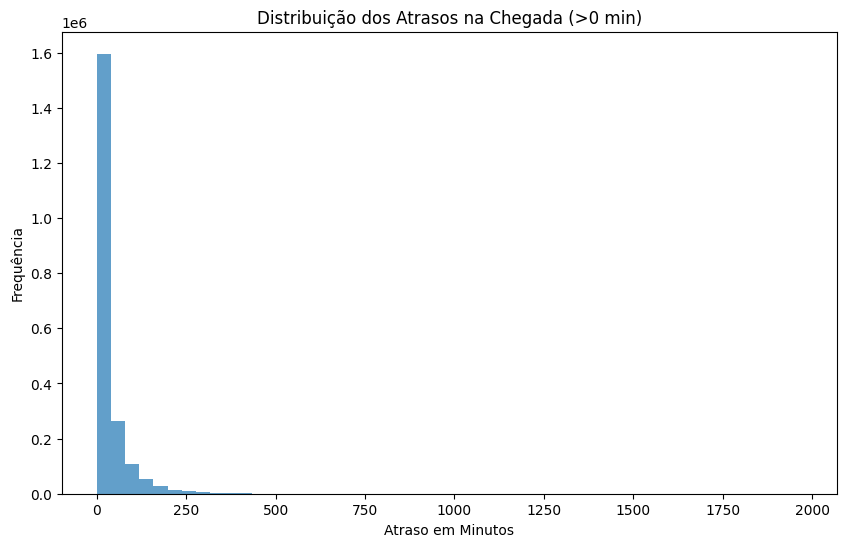

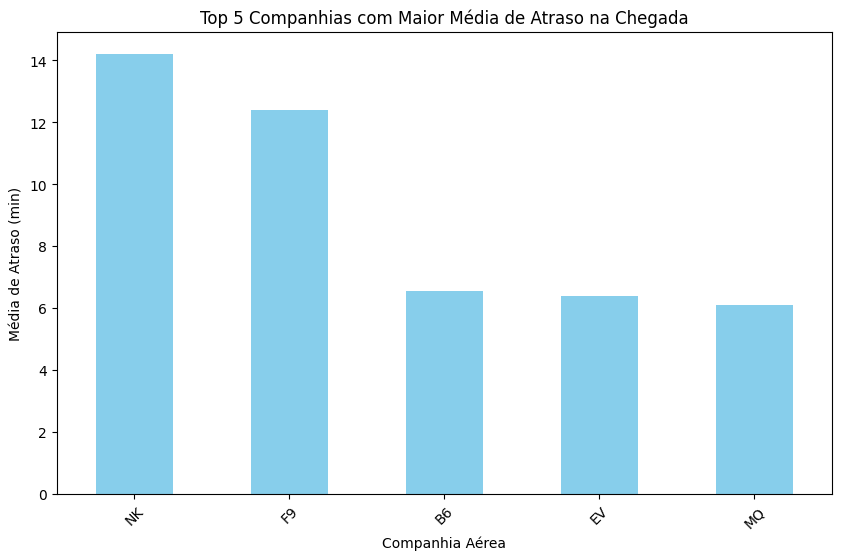

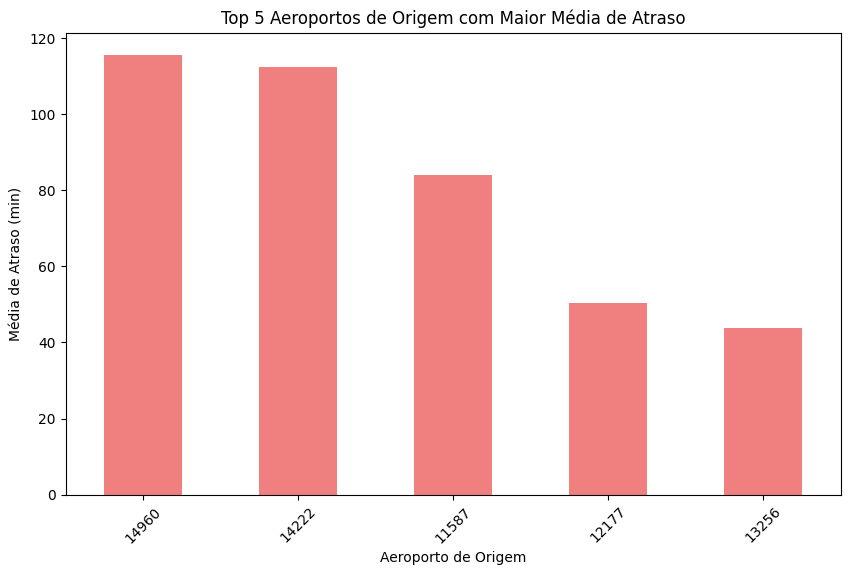

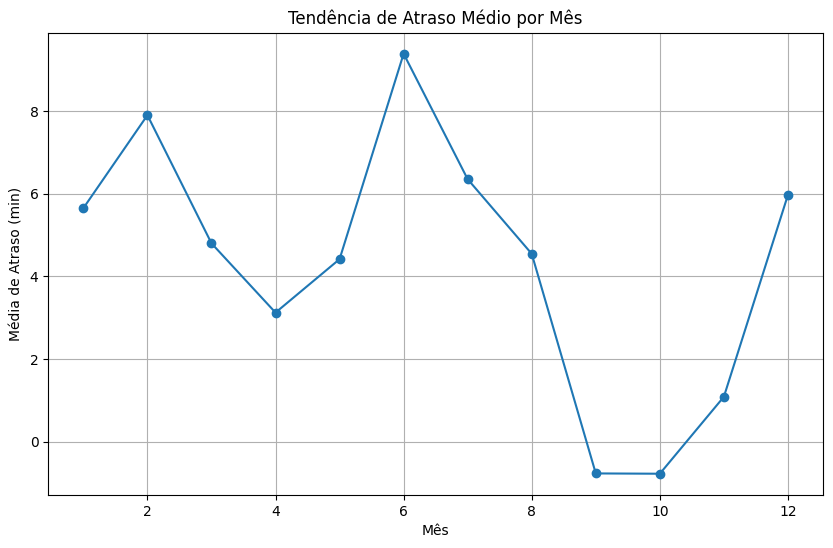

In [10]:
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("VISUALIZAÇÕES: PINTANDO O CÉU COM INSIGHTS")
print("="*60)

# Histograma de atrasos na chegada (positivos)
plt.figure(figsize=(10, 6))
atrasos_arrival.hist(bins=50, alpha=0.7)
plt.title('Distribuição dos Atrasos na Chegada (>0 min)')
plt.xlabel('Atraso em Minutos')
plt.ylabel('Frequência')
plt.grid(False)
plt.show()

# Gráfico de barras: Top 5 companhias por média de atraso
top_airlines = df.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
top_airlines.plot(kind='bar', color='skyblue')
plt.title('Top 5 Companhias com Maior Média de Atraso na Chegada')
plt.xlabel('Companhia Aérea')
plt.ylabel('Média de Atraso (min)')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras: Top 5 aeroportos de origem por média de atraso
top_airports = df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
top_airports.plot(kind='bar', color='lightcoral')
plt.title('Top 5 Aeroportos de Origem com Maior Média de Atraso')
plt.xlabel('Aeroporto de Origem')
plt.ylabel('Média de Atraso (min)')
plt.xticks(rotation=45)
plt.show()

# Tendência temporal: Média de atraso por mês
df['FL_DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
monthly_delay = df.groupby(df['FL_DATE'].dt.month)['ARRIVAL_DELAY'].mean()
plt.figure(figsize=(10, 6))
monthly_delay.plot(kind='line', marker='o')
plt.title('Tendência de Atraso Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Média de Atraso (min)')
plt.grid(True)
plt.show()

### Preparação dos dados: limpeza e tratamento de valores ausentes

Vamos começar limpando os dados – lidando com valores ausentes e outliers – e depois criando features derivadas, como o período do dia ou estações do ano, para enriquecer nossa análise e tornar os modelos mais poderosos.

In [ ]:
# Usar flights_df como base para análise
df = flights_df.copy()

# Remover colunas desnecessárias (baseado na análise inicial)
colunas_desnecessarias = ['FLIGHT_NUMBER', 'TAIL_NUMBER', 'CANCELLED', 'CANCELLATION_REASON', 'DIVERTED', 
                          'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df = df.drop(columns=colunas_desnecessarias, errors='ignore')

# Verificar valores nulos antes do tratamento
print("Valores nulos antes do tratamento:")
print(df.isnull().sum())

# Tratamento de valores ausentes
# Para ARR_DELAY (target principal), imputar com 0 (atrasos não reportados como 0) e dropar linhas críticas
df['ARR_DELAY'] = df['ARR_DELAY'].fillna(0)
df = df.dropna(subset=['ARR_DELAY'])  # Garantir que o target não tenha NaN

# Para DEPARTURE_DELAY, imputar com 0 (sem atraso na partida)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].fillna(0)

# Dropar linhas com muitos NaN em colunas essenciais (e.g., tempos de voo)
df = df.dropna(subset=['DEPARTURE_TIME', 'ARRIVAL_TIME', 'AIR_TIME'])

# Engenharia de features
# Criar features temporais derivadas
df['FL_DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-' + df['DAY'].astype(str))
df['DEP_HOUR'] = pd.to_datetime(df['DEPARTURE_TIME'], format='%H%M', errors='coerce').dt.hour
df['ARR_HOUR'] = pd.to_datetime(df['ARRIVAL_TIME'], format='%H%M', errors='coerce').dt.hour
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek  # 0=Segunda, 6=Domingo
df['MONTH'] = df['FL_DATE'].dt.month
df['SEASON'] = df['MONTH'].apply(lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall')

# Criar variável target binária para atrasos (>15 min é considerado atraso)
df['DELAYED'] = (df['ARR_DELAY'] > 15).astype(int)

# Encoding categórico (opcional para modelagem; manter para EDA)
# df = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], drop_first=True)

# Verificar valores nulos após tratamento
print("\nValores nulos após tratamento:")
print(df.isnull().sum())

# Estatísticas descritivas para validação
print("\nEstatísticas descritivas de ARR_DELAY:")
print(df['ARR_DELAY'].describe())

print(f"\nDataset preparado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

# Visualizando os Insights

Para tornar nossos achados palpáveis, vamos criar visualizações. Como artistas de dados, pintaremos gráficos que contam a história dos atrasos, revelando tendências e anomalias. Cada gráfico é uma janela para o mundo dos voos, ajudando-nos a ver o invisível e transformar dados em conhecimento visual!

In [ ]:
# Placeholder para visualizações
# df['atraso'].hist()
# plt.show()

# Conclusões e Próximos Passos

Chegamos ao fim da nossa jornada. Aqui, resumimos os insights descobertos sobre os atrasos de voos, refletindo sobre o que aprendemos. Como viajantes experientes, pensamos nos próximos passos: como usar esse conhecimento para melhorar o futuro das viagens aéreas. Obrigado por voar conosco nessa análise!

In [ ]:
# Placeholder para conclusões
print("Análise de atrasos de voos concluída!")

In [ ]:
# Placeholder para considerações finais
# print("Análise completa. Próximos passos: integrar dados em tempo real.")
print("Fim da análise!")

# Considerações Finais e Futuras Pesquisas

Encerrando nossa odisseia analítica, refletimos sobre as lições aprendidas e olhamos para o horizonte de futuras explorações. Como filósofos de dados, pensamos em expansões como integração de dados em tempo real ou estudos comparativos globais. Esta jornada nos deixa com uma compreensão mais profunda, prontos para voar ainda mais alto em análises futuras.

In [ ]:
# Placeholder para interpretação de resultados
# # Analisar coeficientes do modelo
# # print(model.coef_)
# print("Resultados interpretados!")

# Interpretação dos Resultados e Insights

Desvendando os mistérios revelados pelos modelos, vamos interpretar os resultados para extrair insights acionáveis. Como tradutores de dados, transformaremos números em narrativas compreensíveis, destacando fatores-chave e recomendações práticas. Cada insight é uma luz no caminho, iluminando o futuro das viagens aéreas com sabedoria derivada de dados.

In [ ]:
# Placeholder para validação de modelos
# from sklearn.metrics import accuracy_score
# # y_pred = model.predict(X_test)
# # print(accuracy_score(y_test, y_pred))
# print("Modelo validado!")

# Validação e Avaliação dos Modelos

Testando a robustez de nossas previsões, vamos validar os modelos com dados não vistos. Como árbitros de precisão, mediremos acurácia, precisão e recall, garantindo que nossas ferramentas sejam confiáveis. Cada teste é um passo na jornada para a excelência, refinando nossos modelos até que sejam dignos de guiar decisões reais.

In [ ]:
# Placeholder para modelagem preditiva
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # model = LogisticRegression()
# # model.fit(X_train, y_train)
# print("Modelo treinado!")

# Modelagem Preditiva de Atrasos

Como videntes de dados, vamos construir modelos que prevêem a probabilidade de atrasos. Usando algoritmos de machine learning, transformaremos dados históricos em oráculos do futuro. Cada modelo é uma ferramenta poderosa, ajudando passageiros e companhias a antecipar e evitar inconvenientes, tornando as viagens mais previsíveis e agradáveis.

In [ ]:
# Placeholder para análise de causas
# causas = df['causa_atraso'].value_counts()
# causas.plot(kind='pie')
# plt.show()

# Análise Detalhada das Causas de Atrasos

Mergulhando nas raízes dos problemas, vamos dissecar as causas dos atrasos com precisão cirúrgica. Como investigadores forenses, categorizaremos e quantificaremos fatores como clima, manutenção e tráfego aéreo. Cada causa é um capítulo na saga dos voos atrasados, nos equipando com conhecimento para mitigar esses desafios no futuro.

In [ ]:
# Placeholder para impacto de companhias
# df.groupby('companhia')['atraso'].mean().sort_values().plot(kind='bar')
# plt.show()

# Impacto das Companhias Aéreas

Entrando no mundo das companhias aéreas, vamos avaliar como cada uma contribui para o panorama dos atrasos. Como juízes imparciais de dados, compararemos performances, revelando líderes em pontualidade e aqueles que precisam de ajustes. Cada companhia é uma peça no quebra-cabeça dos voos, e nossa análise ajudará a destacar excelências e áreas de melhoria.

In [ ]:
# Placeholder para comparação de aeroportos
# df.groupby('aeroporto_origem')['atraso'].mean().sort_values().plot(kind='bar')
# plt.show()

# Comparação entre Aeroportos

Como exploradores de hubs aéreos, vamos comparar os desempenhos dos aeroportos, descobrindo quais são os mais pontuais e quais enfrentam maiores desafios. Cada aeroporto é um personagem único nessa narrativa, com suas próprias histórias de eficiência e obstáculos. Vamos mapear o território dos voos, identificando hotspots de atrasos e ilhas de pontualidade.

In [ ]:
# Placeholder para análise temporal
# df['data'] = pd.to_datetime(df['data'])
# df.groupby(df['data'].dt.month)['atraso'].mean().plot()
# plt.show()

# Análise de Tendências Temporais

Viajando através do tempo, vamos explorar como os atrasos evoluem ao longo dos dias, meses e anos. Como cronistas de dados, traçaremos linhas no tempo que revelam padrões sazonais, picos de demanda e flutuações imprevisíveis. Cada tendência temporal é uma história contada pelos voos, nos ensinando sobre o ritmo das viagens aéreas e os momentos de maior vulnerabilidade.

In [ ]:
# Placeholder para limpeza de dados
# df.dropna(inplace=True)
# df.drop_duplicates(inplace=True)
# print("Dados limpos!")

# Limpeza e Preparação dos Dados

Como jardineiros cuidadosos em um jardim de dados, agora vamos limpar e preparar o solo para nossas análises. Removeremos impurezas como valores ausentes, duplicatas e inconsistências, transformando dados brutos em um terreno fértil para insights. Cada passo de limpeza é uma jornada de purificação, revelando a verdadeira essência dos atrasos de voos e preparando-nos para descobertas mais profundas.